In [2]:
import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import copy

from tqdm import tqdm
import pandas as pd

import os

import nexusformat.nexus as nex

f = nex.nxload("f:\\git\\eeg_prep\\processed_files\\001_000500_000500.hdf5")

# f = nex.nxload("/media/dan/Data/data/sourcesink_eegprep_calculations/processed_files/001_000500_000500.hdf5")
print(f.tree)

root:NXroot
  @date_created = '2024-10-03 16:02:40'
  @description = 'HDF5 file containing iEEG data and calculation...'
  data:NXgroup
    @description = 'windows are shaped (winsize_samps, len(channel...'
    A_mask = bool(609)
    A_mats = float64(118x118x609)
    A_mean = float64(118x118x1)
    A_medians = float64(609)
    A_thresh = 4.466130102425403
    window_indexs = int64(609x2)
    window_reconstructionError = float64(609)
    windows = float64(512x118x609)
  metadata:NXgroup
    N_samples = 312064
    N_wins = 609
    STEPSIZE_MSEC = 500
    STEPSIZE_SAMPS = 512
    WINSIZE_MSEC = 500
    WINSIZE_SAMPS = 512
    channels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', '...
    patient_info:NXgroup
      aal = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      aal2 = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      age_days_at_recording = float64(118)
      age_years_at_recording = float64(118)
      bad_channel = ['False', 'False', 'F

In [3]:
hdf5_path = "F:\\git\\eeg_prep\\processed_files"
# hdf5_path = "/media/dan/Data/git/eeg_prep/processed_files"

files = os.listdir(hdf5_path)
    
# load all files into individual lists
channels = {}
brainnetome = {}
harvard_oxford = {}
miccai = {}
aal = {}
white_matter = {}
soz = {}
ilae = {}
pids = []
a_mats = {}
a_masks = {}
raw_data = {}


for f in tqdm(files):
    if f.endswith(".hdf5"):
        pid = int(f.split("_")[0])
        pids.append(pid)
        with h5py.File(os.path.join(hdf5_path,f), "r") as f:
            channels[pid] = f['metadata']["channels"][:]
            brainnetome[pid] = f['metadata']['patient_info']["brainnetome"][:]
            harvard_oxford[pid] = f['metadata']['patient_info']["harvard-oxford"][:]
            miccai[pid] = f['metadata']['patient_info']["miccai"][:]
            aal[pid] = f['metadata']['patient_info']["aal"][:]
            white_matter[pid] = f['metadata']['patient_info']["white_matter"][:].astype(bool)
            # convert from bytes to string
            channels[pid] = [x.decode('utf-8') for x in channels[pid]]
            brainnetome[pid] = [x.decode('utf-8') for x in brainnetome[pid]]
            harvard_oxford[pid] = [x.decode('utf-8') for x in harvard_oxford[pid]]
            miccai[pid] = [x.decode('utf-8') for x in miccai[pid]]
            aal[pid] = [x.decode('utf-8') for x in aal[pid]]

            soz[pid] = f['metadata']["patient_info"]['soz'][:].astype(bool)
            ilae[pid] = f['metadata']["patient_info"]['ilae'][:]

            a_mats[pid] = f['data']['A_mats'][:]
            a_masks[pid] = f['data']['A_mask'][:].astype(bool)
            # raw_data[pid] = f['data']['windows'][:]

100%|██████████| 72/72 [00:30<00:00,  2.38it/s]


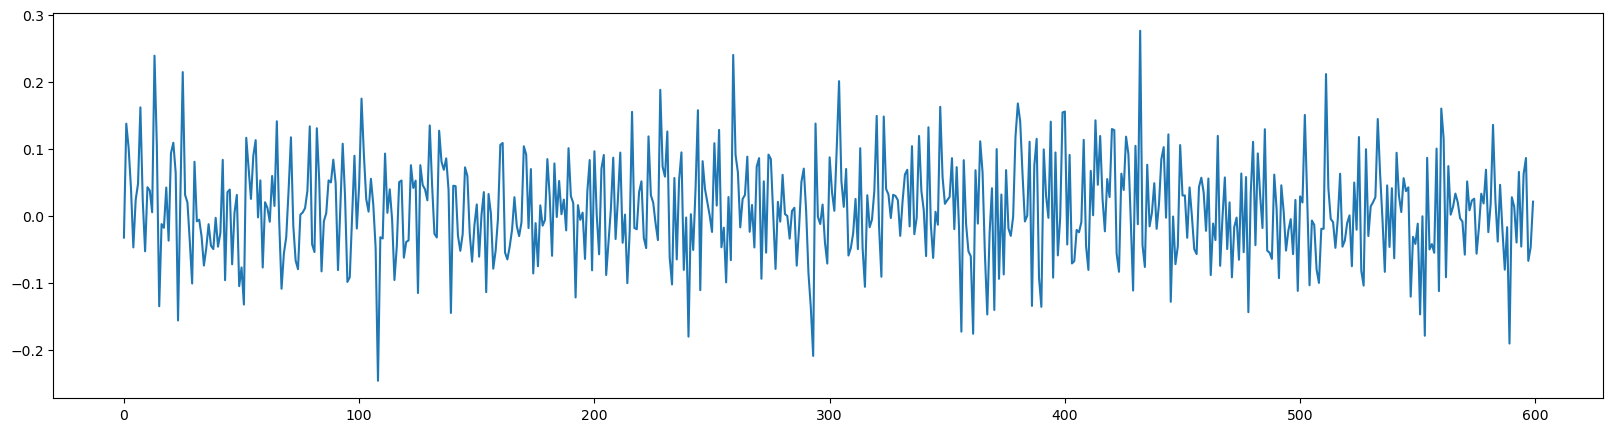

In [4]:
pid = 64
As = a_mats[pid][:,:, a_masks[pid]]
# diags = np.zeros((As.shape[0],As.shape[-1]))

# for i in range(As.shape[-1]):
#     diags[:,i] = np.diag(As[:,:,i])
#     np.fill_diagonal(As[:, :, i], 0)

# As = np.diff(As,axis=-1)

# normalize 0-1
# tot_mag = tot_mag / np.max(tot_mag)

s = soz[pid]
soz_soz = As[s, :, :][:, s, :]
soz_noz = As[s, :, :][:, ~s,:]
noz_soz = As[~s, :, :][:, s,:]
noz_noz = As[~s, :,:][:, ~s,:]
plt.figure(figsize=(20,5))
plt.plot(As[2,1,:])

In [7]:
def get_diags(matrix):
    diags = np.zeros((matrix.shape[0],matrix.shape[-1]))
    for i in range(matrix.shape[-1]):
        diags[:,i] = np.diag(matrix[:,:,i])
    return diags
def get_non_diags(matrix):
    n = matrix.shape[0]**2 - matrix.shape[0]
    non_diags = np.zeros((n,matrix.shape[-1]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if i == j:
                continue
            non_diags[i,:] = matrix[i,j,:]
    return non_diags


# diags = get_diags(soz_soz)
# non_diags = get_non_diags(soz_soz)


In [9]:
def plot_timeseries(mat, title=None):
    fig,ax = plt.subplots(1,1,figsize=(20,5))
    for r in range(mat.shape[0]):
        for c in range(mat.shape[1]):
            if sum(mat[r,c,:]) == 0:
                continue
            ax.plot(mat[r,c,:],label=f"{r},{c}", alpha=0.45, color='b', linewidth=.2)
    plt.grid()
    if title is not None:
        plt.title(title)
# plt.plot(diags.T);
# for i in range(diags.shape[0]):
#     plt.figure()
#     plt.plot(diags[i,:])
#     plt.title(f"Diagonal {i}") 

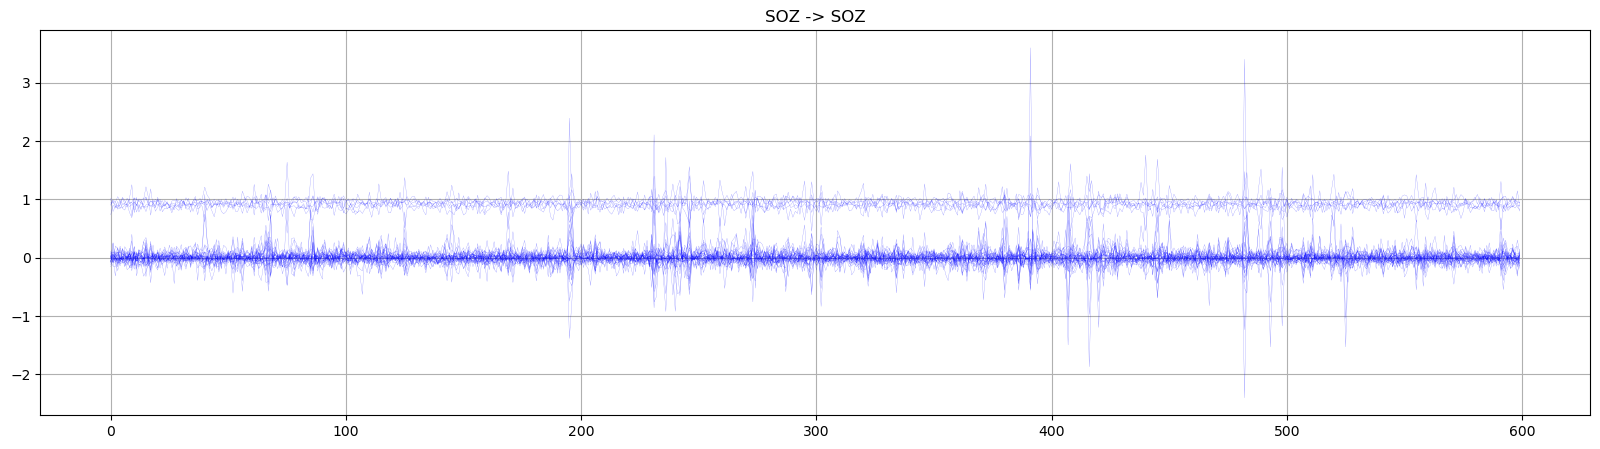

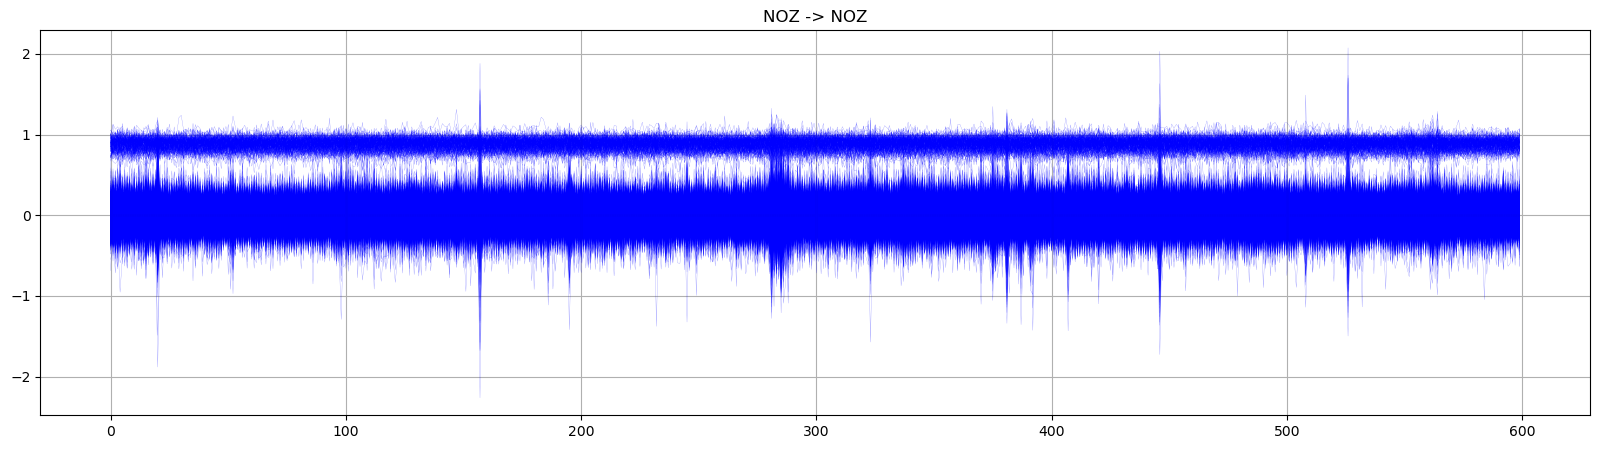

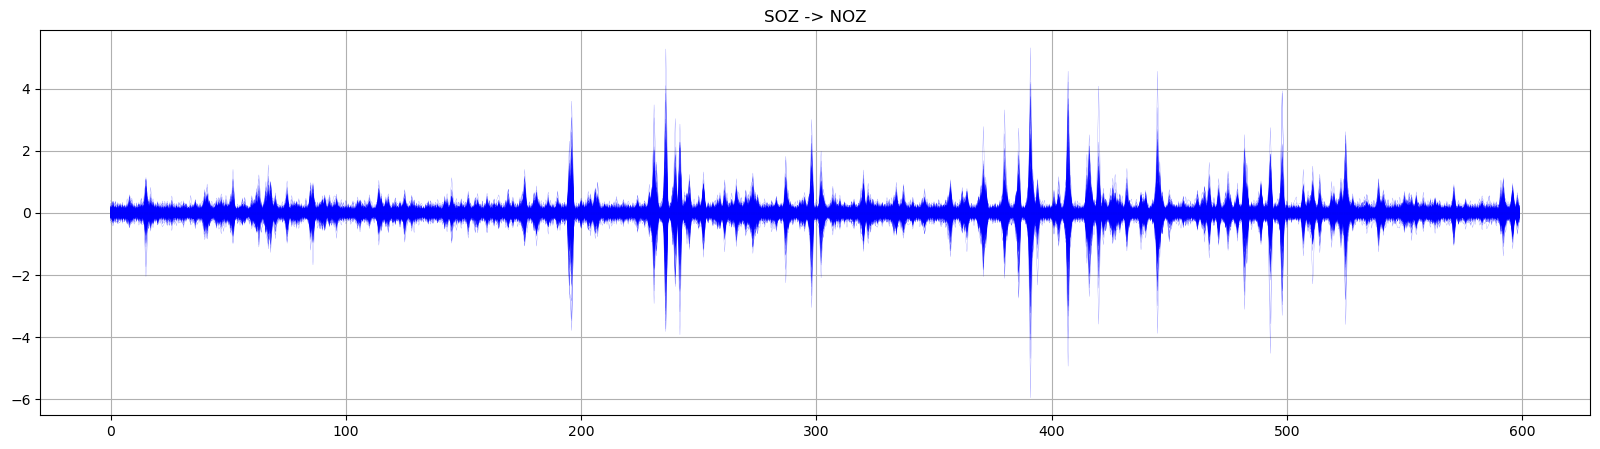

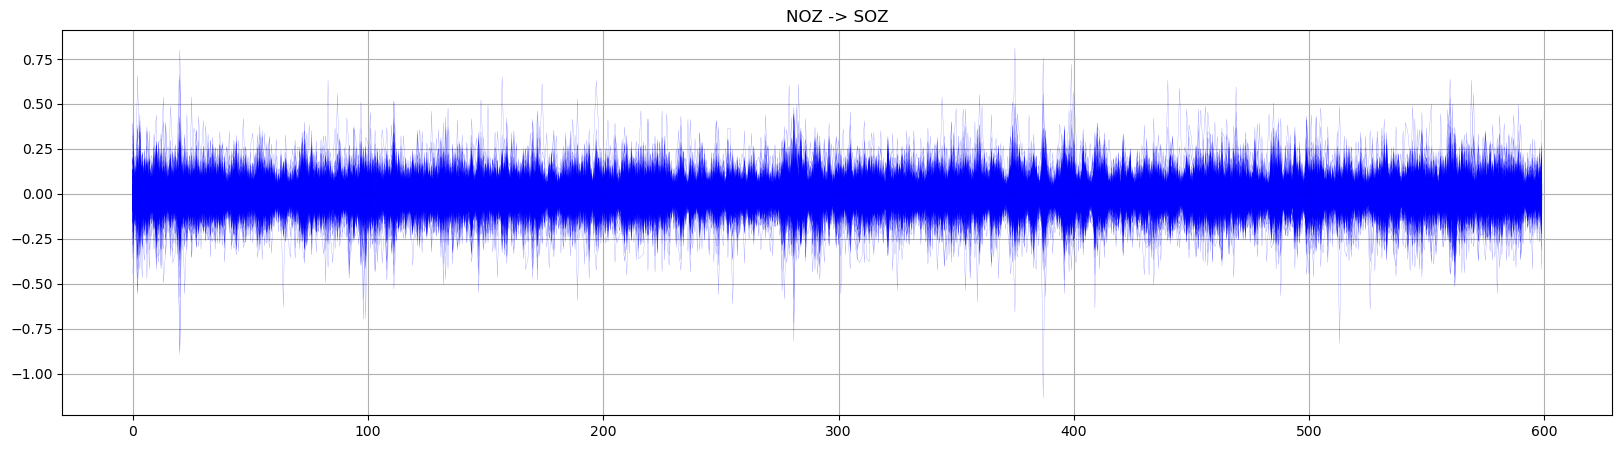

In [10]:
plot_timeseries(soz_soz, "SOZ -> SOZ")
plot_timeseries(noz_noz, "NOZ -> NOZ")
plot_timeseries(soz_noz, "SOZ -> NOZ")
plot_timeseries(noz_soz, "NOZ -> SOZ")

In [48]:
tick_positions = [idx for idx, value in enumerate(s) if value]

for i in tqdm(range(As.shape[-1])):
    plt.figure()
    ax = sns.heatmap(As[:,:,i],cmap="seismic",square=True,vmin=-2,vmax=2)
    ax.set_xticks([])
    ax.set_yticks([])
   
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.axis("equal")
    plt.title(f"Time {i:04}")
    plt.savefig(os.path.join('F:\\git\\network_miner\\temp\\diffs', f"{i:04}.png"))
    plt.close()


100%|██████████| 599/599 [02:30<00:00,  3.99it/s]


In [5]:
As = a_mats[pid][:,:, a_masks[pid]]
tick_positions = [idx for idx, value in enumerate(s) if value]

for i in tqdm(range(As.shape[-1])):
    plt.figure()
    ax = sns.heatmap(As[:,:,i],cmap="seismic",square=True,vmin=-2,vmax=2)
    ax.set_xticks([])
    ax.set_yticks([])
   
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.axis("equal")
    plt.title(f"Time {i:04}")
    plt.savefig(os.path.join('F:\\git\\network_miner\\temp\\As', f"{i:04}.png"))
    plt.close()


100%|██████████| 600/600 [02:24<00:00,  4.15it/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def recurrence_plot(data, threshold=0.1):
    """
    Generate a recurrence plot from a time series.

    :param data: Time series data
    :param threshold: Threshold to determine recurrence
    :return: Recurrence plot
    """
    # Calculate the distance matrix
    N = len(data)
    distance_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_matrix[i, j] = np.abs(data[i] - data[j])

    # Create the recurrence plot
    recurrence_plot = np.where(distance_matrix <= threshold, 1, 0)

    return recurrence_plot

In [6]:
s[1]

False

In [12]:
for i in tqdm(range(As.shape[0])):
    for j in tqdm(range(As.shape[1])):
        # label soz->soz, soz->noz, noz->soz, noz->noz  
        if s[i]==True and s[j]==True:
            label = "soz->soz"  
        elif s[i]==True and s[j]==False:
            label = "noz->soz"
        elif s[i]==False and s[j]==True:
            label = "soz->noz"
        else:
            label = "noz->noz"
        rec = recurrence_plot(As[i,j,:],threshold=np.std(As[i,j,:])*.2)
        plt.figure(figsize=(8,8),dpi=300)
        plt.imshow(rec, cmap='binary', origin='lower')
        string_i = f"{s[i]}"[0].upper()
        string_j = f"{s[j]}"[0].upper()
        plt.title(f"{i:04}|{string_i}, {j:04}|{string_j}  ||  {label}")
        plt.savefig(os.path.join('F:\\git\\network_miner\\temp\\recurrence', f"{i:04}_{j:04}.png"))
        plt.close()


  1%|          | 1/192 [06:58<22:13:08, 418.79s/it]


KeyboardInterrupt: 

In [45]:
for i in tqdm(range(soz_soz.shape[-1])):
    plt.figure()
    ax =sns.heatmap(soz_soz[:,:,i],cmap="seismic",square=True,vmin=-1,vmax=1)
    
    plt.axis("equal")
    plt.title(f"Time {i:04}")
    plt.savefig(os.path.join('F:\\git\\network_miner\\temp\\soz_adiffs', f"{i:04}.png"))
    plt.close()


100%|██████████| 599/599 [01:18<00:00,  7.60it/s]


In [46]:


import os
from PIL import Image
import imageio

# Set your folder path and output file name
folder_path = 'F:\\git\\network_miner\\temp\\soz_adiffs'
output_file = 'diffgif.gif'

# List all image files in the folder
images = []
for file_name in sorted(os.listdir(folder_path)):
    if file_name.endswith(('png', 'jpg', 'jpeg', 'bmp')):
        file_path = os.path.join(folder_path, file_name)
        images.append(imageio.imread(file_path))

# Create and save the GIF
imageio.mimsave(output_file, images, fps=60, loop=0)  # fps sets the speed of the gif

print(f"GIF saved as {output_file}")

C:\Users\wirel\AppData\Local\Temp\ipykernel_11228\1802757273.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved as diffgif.gif


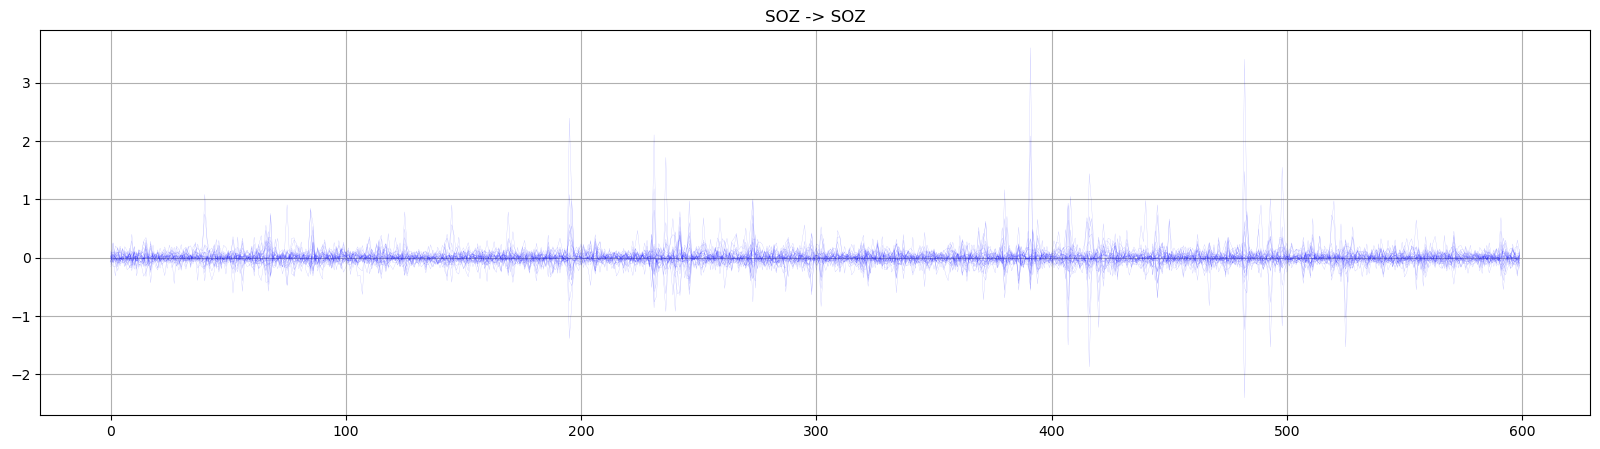

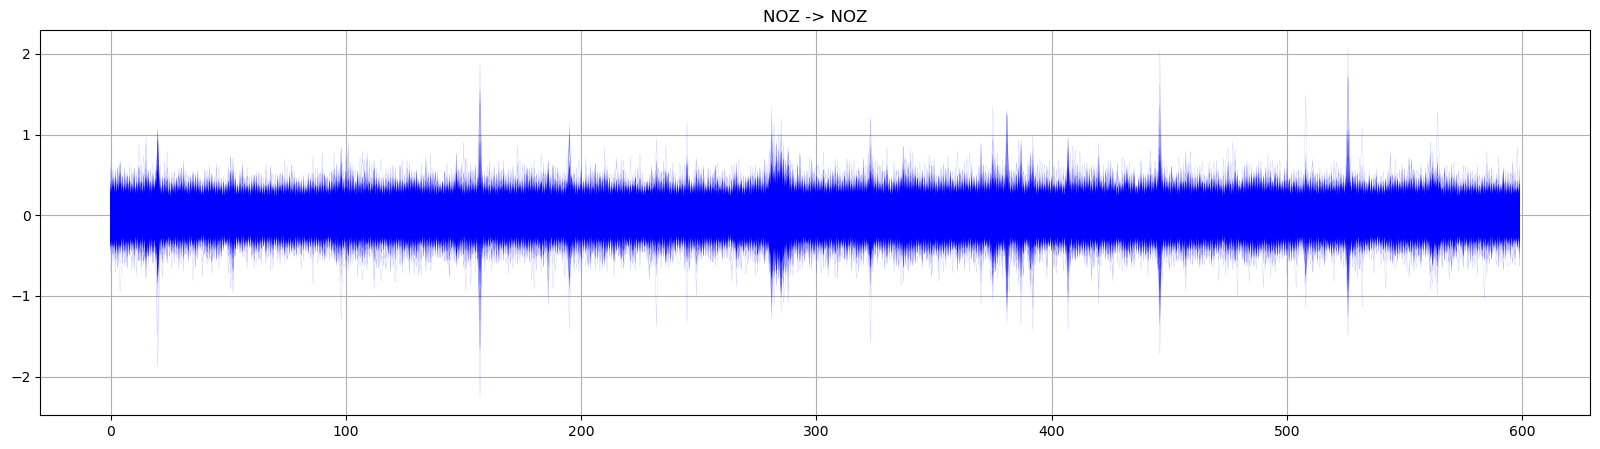

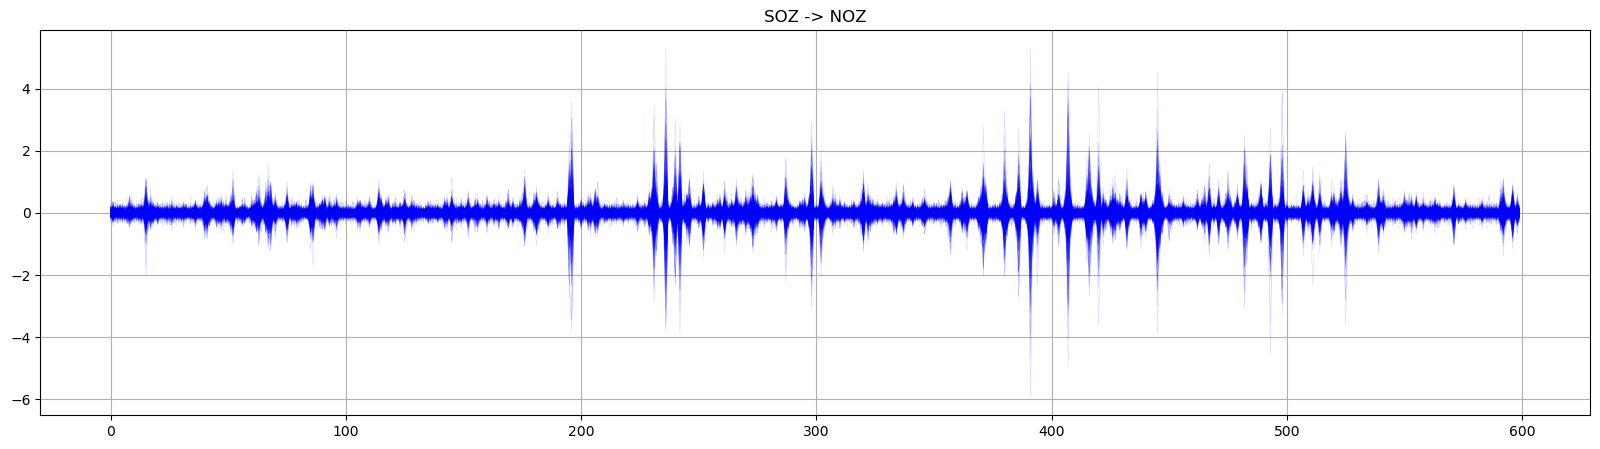

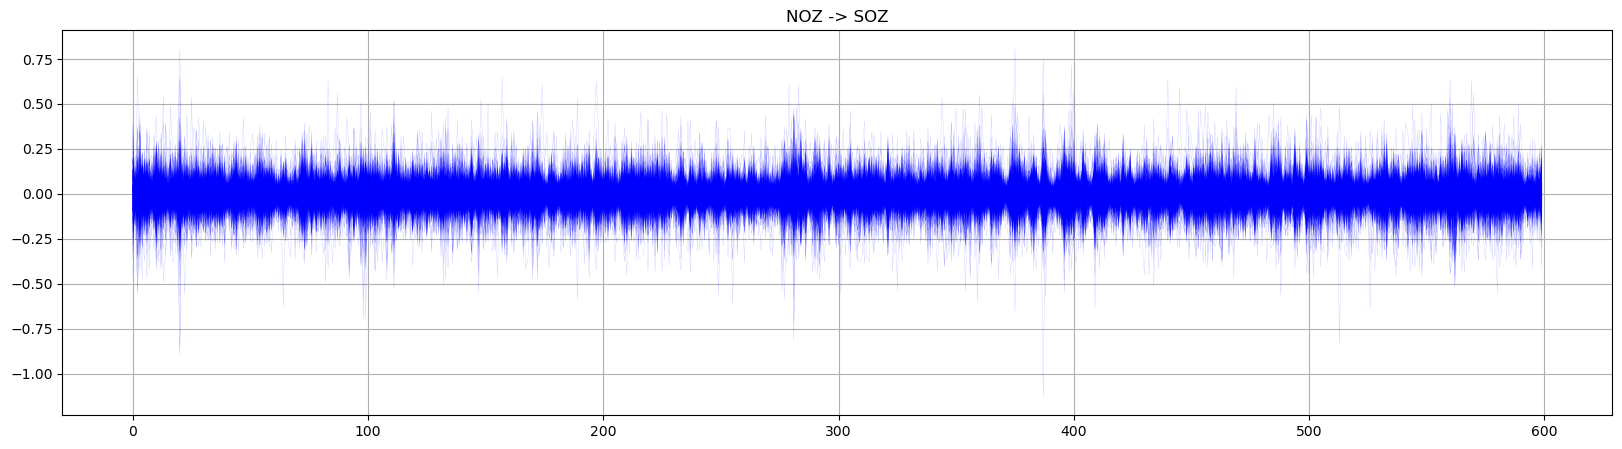